In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: /Users/evanli/Documents/Bmi_NAS_evan/evan_home


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
import copy


/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata.shape  # row is cells, column is gene

(161764, 33538)

In [3]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [4]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.4895154535770416
Row 0, Column 43, Value 0.8167138695716858
Row 0, Column 48, Value 0.8167138695716858
Row 0, Column 53, Value 0.8167138695716858
Row 0, Column 55, Value 1.424944519996643
Row 0, Column 66, Value 0.4895154535770416
Row 0, Column 77, Value 0.8167138695716858
Row 0, Column 78, Value 1.424944519996643
Row 0, Column 89, Value 0.8167138695716858
Row 0, Column 93, Value 1.0628387928009033
Row 0, Column 102, Value 0.8167138695716858
Row 0, Column 154, Value 2.4626553058624268
Row 0, Column 178, Value 0.8167138695716858
Row 0, Column 185, Value 0.4895154535770416
Row 0, Column 190, Value 0.4895154535770416
Row 0, Column 201, Value 1.8004224300384521
Row 0, Column 224, Value 0.8167138695716858
Row 0, Column 240, Value 0.4895154535770416
Row 0, Column 259, Value 0.4895154535770416
Row 0, Column 261, Value 1.566353440284729


In [5]:
all_zero_cols = adata.X.getnnz(axis=0) == 0
zero_cols_count = np.sum(all_zero_cols)
print('No. of columns with all zeros:', zero_cols_count)  # 6034


No. of columns with all zeros: 6034


In [6]:
# Remove columns with all zeros
adata = adata[:, ~all_zero_cols]
print('New shape of adata.X:', adata.X.shape)
print('New shape of adata.var:', adata.var.shape)

New shape of adata.X: (161764, 27504)
New shape of adata.var: (27504, 0)


In [7]:
# All level 1 celltypes
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(" ", "_")
adata.obs['celltype.l3'] = adata.obs['celltype.l3'].str.replace(" ", "_")
types = np.unique(adata.obs['celltype.l1']).tolist()
print(types)
# cell count in each celltype
adata.obs['celltype.l1'].value_counts()

C:\Users\evanlee\AppData\Local\Temp\ipykernel_8404\3394596873.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")


['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


celltype.l1
Mono       49010
CD4_T      41001
CD8_T      25469
NK         18664
B          13800
other_T     6789
DC          3589
other       3442
Name: count, dtype: int64

In [8]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## UMAP with stored embedding in Hao_PBMC_scaled_Harmony.h5ad

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

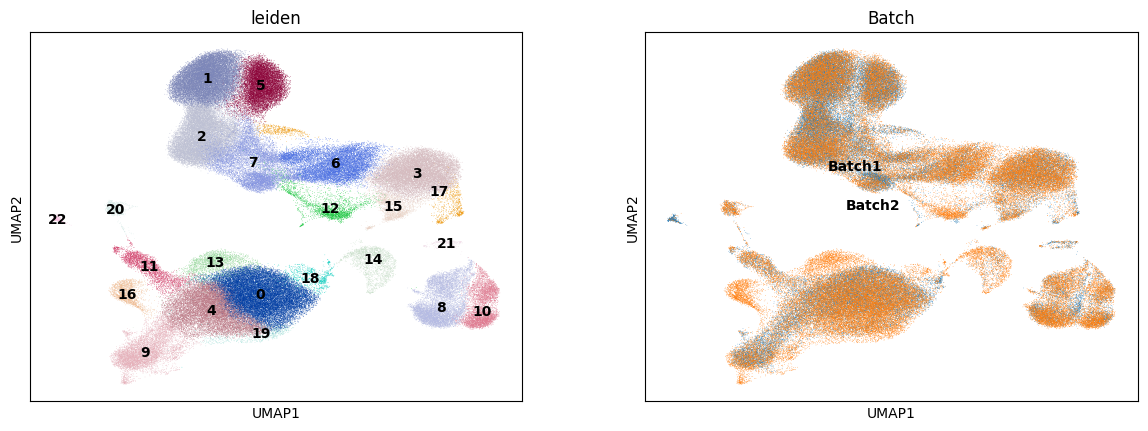

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

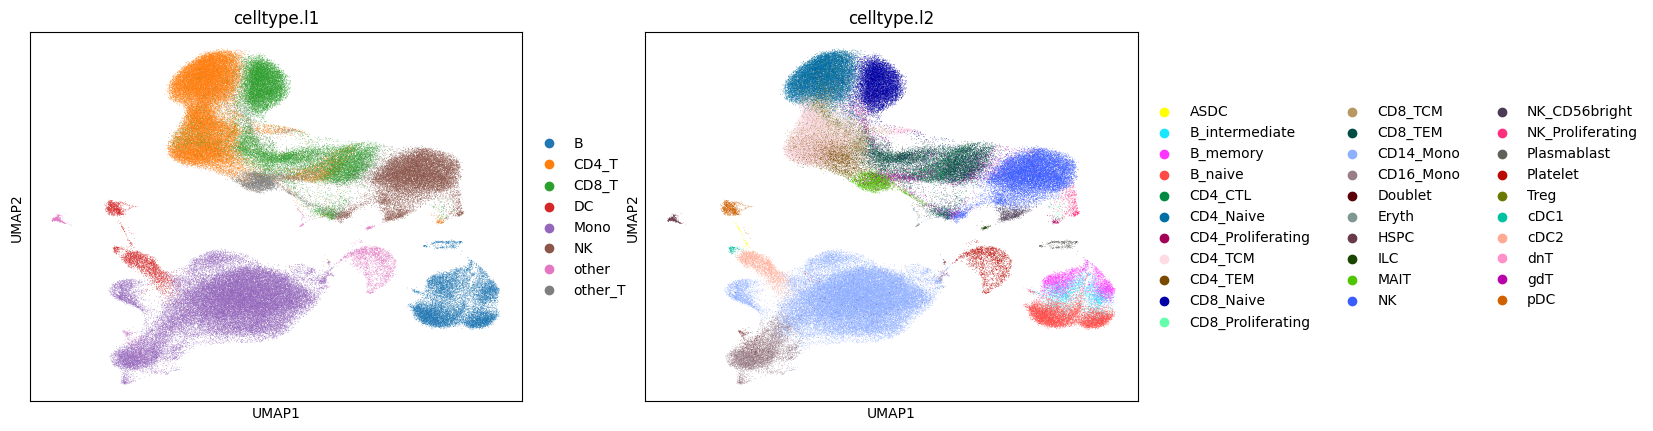

In [9]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [10]:
umap_adja_matrix = adata.obsp['connectivities']  # derived from sc.pp.neighbors()
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3703678 stored elements in Compressed Sparse Row format>

In [11]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1851839 edges
161764


In [12]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

# Keys are cell index, values are the corresponding clustering coefficient

Key: 0, Value: 0.13157894736842105
Key: 1, Value: 0.1323529411764706
Key: 2, Value: 0.17582417582417584
Key: 3, Value: 0.10476190476190476
Key: 4, Value: 0.11052631578947368
Key: 5, Value: 0.17647058823529413
Key: 6, Value: 0.13333333333333333
Key: 7, Value: 0.13333333333333333
Key: 8, Value: 0.13725490196078433
Key: 9, Value: 0.09523809523809523


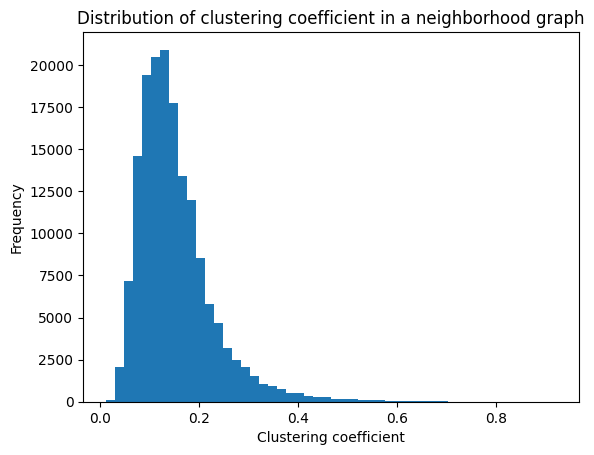

In [13]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.title('Distribution of clustering coefficient in a neighborhood graph')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [14]:
# selection criteria
inv_percentage = pd.read_csv('L1_log(count)_inv_percentage.csv', index_col=0)
inv_percentage

,Original count,log10(count),Percentage,Selected count
Mono,49010,4.690285,0.200000,9802
CD4_T,41001,4.612794,0.253744,10404
CD8_T,25469,4.406012,0.397159,10116
NK,18664,4.271005,0.490795,9161
B,13800,4.139879,0.581738,8028
other_T,6789,3.831806,0.795404,5400
DC,3589,3.554973,0.987403,3544
other,3442,3.536811,1.000000,3442


In [15]:
import math
# Select top percentage clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    print('====================')
    # get percentage
    percentage = inv_percentage.loc[celltype, 'Percentage']
    print(celltype, percentage)

    # select cells from one celltype
    celltype_idx = np.where(adata.obs['celltype.l1'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top_count = math.ceil(len(celltype_coeff) * percentage)
    print('top count', top_count)
    top_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top_count]  # sort celltype_coeff by value (descending)
    # print(top_indices)
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top_indices}
    # print(celltype_selected)
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))


B 0.581737738
top count 8028
B 8028
CD4_T 0.253743917
top count 10404
CD4_T 10404
CD8_T 0.397159433
top count 10116
CD8_T 10116
DC 0.987403205
top count 3544
DC 3544
Mono 0.2
top count 9802
Mono 9802
NK 0.490794616
top count 9161
NK 9161
other 1.0
top count 3442
other 3442
other_T 0.795404155
top count 5400
other_T 5400


In [16]:
len(alltype_selected)

59897

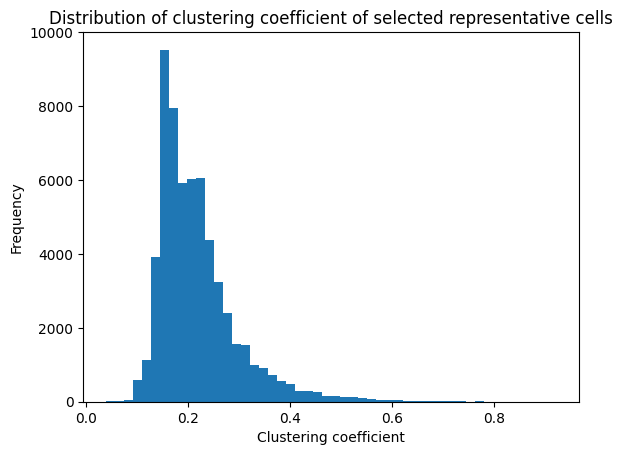

In [17]:
# Plot the distribution of clustering coefficients of selected representative cells
import matplotlib.pyplot as plt
coefs = list(alltype_selected.values())
plt.title('Distribution of clustering coefficient of selected representative cells')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [18]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata.obs['is_representative'] = is_representative
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No


In [19]:
sum(adata.obs['is_representative'] == 'Yes')

59897

In [20]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata.shape[0]):
    if adata.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata.obs['is_representative'][i] + '_' + adata.obs['celltype.l1'][i])
    else:
        # No
        clus_rep.append(adata.obs['is_representative'][i])

adata.obs['cluster_representative'] = clus_rep

C:\Users\evanlee\AppData\Local\Temp\ipykernel_8404\2156152308.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['is_representative'][i] == 'Yes':
C:\Users\evanlee\AppData\Local\Temp\ipykernel_8404\2156152308.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clus_rep.append(adata.obs['is_representative'][i])
C:\Users\evanlee\AppData\Local\Temp\ipykernel_8404\2156152308.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

In [21]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_T
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No,No


## Plot representative cell UMAP

In [22]:
### Get palette
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Get colors from sc.pl.umap() plot
l1_colors = adata.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors = adata.uns['celltype.l2_colors']
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


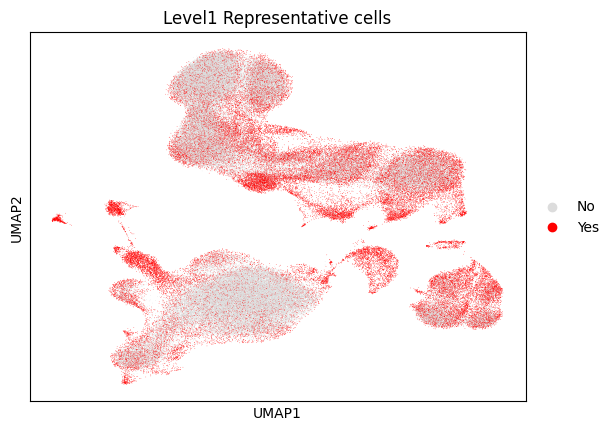

In [23]:
# Plot Yes/No representative cells
sc.pl.umap(adata, color='is_representative', title='Level1 Representative cells', palette=['#dcdcdc', 'red'])

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


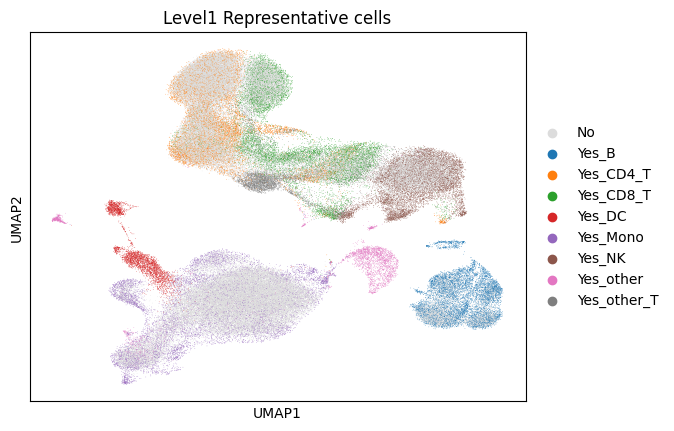

In [24]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata, color='cluster_representative', title='Level1 Representative cells', palette=['#dcdcdc']+l1_colors.tolist())

## Export representative cells adata

In [25]:
adata_rep_cells = adata[adata.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(59897, 27504)

In [26]:
os.chdir(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ")

In [27]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 6, Value 0.4895154535770416
Row 0, Column 37, Value 0.8167138695716858
Row 0, Column 42, Value 0.8167138695716858
Row 0, Column 47, Value 0.8167138695716858
Row 0, Column 49, Value 1.424944519996643
Row 0, Column 57, Value 0.4895154535770416
Row 0, Column 68, Value 0.8167138695716858
Row 0, Column 69, Value 1.424944519996643
Row 0, Column 80, Value 0.8167138695716858
Row 0, Column 84, Value 1.0628387928009033
Row 0, Column 93, Value 0.8167138695716858
Row 0, Column 129, Value 2.4626553058624268
Row 0, Column 151, Value 0.8167138695716858
Row 0, Column 156, Value 0.4895154535770416
Row 0, Column 161, Value 0.4895154535770416
Row 0, Column 171, Value 1.8004224300384521
Row 0, Column 193, Value 0.8167138695716858
Row 0, Column 209, Value 0.4895154535770416
Row 0, Column 227, Value 0.4895154535770416
Row 0, Column 229, Value 1.566353440284729


In [28]:
adata_rep_cells.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_T
L1_AAACCCACATCAGTCA,CD8_T,CD8_TEM,CD8_TEM_1,Batch1,P3,2,L1,G1,5297,212,4332,1633,6,Yes,Yes_CD8_T
L1_AAACCCAGTGGAACAC,NK,NK,NK_2,Batch1,P1,2,L1,G2M,2847,201,3251,1375,3,Yes,Yes_NK
L1_AAACGAAAGGCCCAAA,Mono,CD14_Mono,CD14_Mono,Batch1,P4,0,L1,G1,8989,221,6866,2000,0,Yes,Yes_Mono
L1_AAACGAAAGTTGAATG,other_T,MAIT,MAIT,Batch1,P3,7,L1,S,3978,210,3543,1255,7,Yes,Yes_other_T


In [29]:
adata_rep_cells.write_h5ad('Hao_L1_repcells_loginv_Harmony_noZ.h5ad')

In [30]:
np.unique(adata_rep_cells.obs['celltype.l1']).tolist()

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']